In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
import os
import scipy.io
import math
import sys

from sklearn.utils import shuffle

from PIL import Image
import requests
from io import BytesIO

from tensorflow.keras.applications import resnet50
from keras.preprocessing import image

import matplotlib.pyplot as plt

import numpy as np
#from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

import tensorflow as tf
from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from scipy import spatial
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
resnet_weights_path = '../input/models/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

In [3]:
resnet50_model = resnet50.ResNet50(weights=resnet_weights_path)

In [4]:
styles = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv', error_bad_lines=False)

shirts = styles[styles['articleType'].isin(['Shirts'])]
tshirts = styles[styles['articleType'].isin(['Tshirts'])]
pants =  styles[styles['articleType'].isin(['Track Pants','Shorts', 'Trunk', 'Trousers', 'Track Pants', 'Tights', 'Lounge Pants', 'Lounge Shorts', 'Leggings', 'Jeans', 'Jeggings'])]
# np.unique(styles['articleType'])
shirts, tshirts, pants = shirts['id'].to_numpy(), tshirts['id'].to_numpy(), pants['id'].to_numpy()
shirts.shape, tshirts.shape, pants.shape

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

((3217,), (7067,), (2445,))

# Constants

In [5]:
image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'

IMG_SIZE = 224
LIMIT_IMAGES = 1500
NUM_OUTPUTS = 3

# Load Image Files

In [6]:
def load_imgs(names):
    imgs = []
    for i, image_name in enumerate(tqdm(names)):
#         if i% 50 == 0 :
#             print(f"Loading Image {i}")
        try:
            img = image.load_img(f'{image_path}{image_name}.jpg', target_size=(IMG_SIZE, IMG_SIZE))
        except:
            img = None
        if img is None:
            continue
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [7]:
print("Loading Images...")
print("Shirts")
shirt_images = load_imgs(shirts[:LIMIT_IMAGES])
print("TShirts")
tshirt_images = load_imgs(tshirts[:LIMIT_IMAGES])
print("Pants")
pant_images = load_imgs(pants[:LIMIT_IMAGES])
print("Done")
shirt_images.shape, tshirt_images.shape, pant_images.shape

  0%|          | 1/1500 [00:00<04:42,  5.31it/s]

Loading Images...
Shirts


  0%|          | 0/1500 [00:00<?, ?it/s]

TShirts


  0%|          | 0/1500 [00:00<?, ?it/s]

Pants


100%|██████████| 1500/1500 [03:19<00:00,  7.52it/s]


Done


((1498, 224, 224, 3), (1500, 224, 224, 3), (1500, 224, 224, 3))

In [8]:
train_shirt_images, test_shirt_images, _, _ = train_test_split(shirt_images, np.repeat(0, shirt_images.shape[0]), test_size = 0.2)
train_shirt_images.shape, test_shirt_images.shape

((1198, 224, 224, 3), (300, 224, 224, 3))

In [9]:
train_tshirt_images, test_tshirt_images, _, _ = train_test_split(tshirt_images, np.repeat(0, tshirt_images.shape[0]), test_size = 0.2)
train_tshirt_images.shape, test_tshirt_images.shape

((1200, 224, 224, 3), (300, 224, 224, 3))

In [10]:
train_pant_images, test_pant_images, _, _ = train_test_split(pant_images, np.repeat(0, pant_images.shape[0]), test_size = 0.2)
train_pant_images.shape, test_pant_images.shape

((1200, 224, 224, 3), (300, 224, 224, 3))

In [11]:
def get_vectors(imgs):
    processed_batch = preprocess_input(imgs, mode="caffe")
    return resnet50_model.predict(processed_batch)

def get_average_vector(imgs):
    vectors = get_vectors(imgs)
    print(vectors.shape)
    return np.mean(vectors, axis=0)

def closeness(a, b):
#     print(a.shape)
#     print(b.shape)
    return 1 - spatial.distance.cosine(a, b)

def closest(vector, compared_to):
    best = -5
    best_idx = -1
#     print(compared_to.shape)
    for i, cmp in enumerate(compared_to):
        c = closeness(vector, cmp)
        if c > best:
            best_idx = i
            best = c
    return best_idx, best

def b_closest(vectors, compared_to):
    return np.array([closest(vector, compared_to)[0] for vector in vectors])

In [12]:
shirt_vector = get_average_vector(train_shirt_images)
tshirt_vector = get_average_vector(train_tshirt_images)
pant_vector = get_average_vector(train_pant_images)

(1198, 1000)
(1200, 1000)
(1200, 1000)


# Model Results

In [13]:
test_vector = np.array([shirt_vector, tshirt_vector, pant_vector])
print(test_vector)

[[5.7144349e-05 1.3734630e-06 2.1985061e-05 ... 1.9338217e-06
  5.8907033e-05 3.1286888e-04]
 [3.4907815e-05 2.2531281e-06 2.3988536e-05 ... 1.2421723e-06
  5.3607069e-05 7.4739609e-04]
 [2.9209466e-05 1.0474236e-06 6.3101652e-06 ... 6.6463082e-07
  7.4071140e-06 3.3161242e-04]]


In [14]:
train_X = np.concatenate((train_shirt_images, train_tshirt_images, train_pant_images), axis = 0)
train_Y = np.repeat((0, 1, 2), (train_shirt_images.shape[0], train_tshirt_images.shape[0], train_pant_images.shape[0]), axis = 0)

train_vecs = get_vectors(train_X)
train_predictions = b_closest(train_vecs, test_vector)

train_accuracy = accuracy_score(train_Y, train_predictions)
print(f"In Sample Accuracy: {train_accuracy}")

In Sample Accuracy: 0.6459143968871596


In [15]:
test_X = np.concatenate((test_shirt_images, test_tshirt_images, test_pant_images), axis = 0)
test_Y = np.repeat((0, 1, 2), (test_shirt_images.shape[0], test_tshirt_images.shape[0], test_pant_images.shape[0]), axis = 0)

test_vecs = get_vectors(test_X)
test_predictions = b_closest(test_vecs, test_vector)

test_accuracy = accuracy_score(test_Y, test_predictions)
print(f"Out Of Sample Accuracy: {test_accuracy}")

Out Of Sample Accuracy: 0.6588888888888889


# NN To Classify

In [16]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [17]:
trainx, trainy = shuffle(train_vecs, train_Y)
# trainx = np.expand_dims(trainx, axis=1)
print(trainy)
trainx.shape, trainy.shape

[2 2 0 ... 0 2 1]


((3598, 1000), (3598,))

In [18]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=1000, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

In [20]:
kfold = KFold(n_splits=10, shuffle=True)

In [21]:
classify_model = estimator.fit(trainx, trainy)

In [22]:
preds = estimator.predict(train_vecs)
acc = accuracy_score(train_Y, preds)
print(f"In sample Accuracy: {acc}")

In sample Accuracy: 0.9866592551417455


In [23]:
preds = estimator.predict(test_vecs)
acc = accuracy_score(test_Y, preds)
print(f"Out of sample Accuracy: {acc}")

Out of sample Accuracy: 0.9566666666666667


In [24]:
estimator.model.save('/kaggle/working/keras-vlarge-963.h5')

# ADA to classify

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [26]:
abc = AdaBoostClassifier(n_estimators=400, learning_rate=1)
abcm = abc.fit(trainx, trainy)

In [27]:
preds = abc.predict(train_vecs)
acc = accuracy_score(train_Y, preds)
print(f"In sample Accuracy: {acc}")

#print(classification_report(train_Y, preds))

preds = abc.predict(test_vecs)
acc = accuracy_score(test_Y, preds)
print(f"Out of sample Accuracy: {acc}")

#print(classification_report(test_Y, preds))

In sample Accuracy: 0.9791550861589772
Out of sample Accuracy: 0.9633333333333334


In [28]:
import pickle
pickle.dump(abc, open('/kaggle/working/ada-vlarge-964.pickle', 'wb'))

In [29]:
import pickle
with open("/kaggle/working/ada-vlarge-964.pickle", "rb") as f:
    clas = pickle.load(f)
    
    
print(clas)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=400, random_state=None)


In [30]:
IMG_SIZE = 224
NUM_OUTPUTS = 3
classify_model = pickle.load(open("/kaggle/working/ada-vlarge-964.pickle", 'rb'))

labels = ["Shirt", "TShirt", "Pants"]
# labels = ["T-shirt/top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


def tag(image):
  image = image.resize((IMG_SIZE, IMG_SIZE))
  image = np.array(image)
  img_batch = np.expand_dims(image, axis=0)
  processed_batch = preprocess_input(img_batch, mode="caffe")
  vec_batch = resnet50_model.predict(processed_batch)
  pred_batch = classify_model.predict(vec_batch)
  prediction = pred_batch[0]
  print(prediction)
  print(f'{prediction} - { labels[prediction] }')

  return {"tag": str(prediction), "label": labels[prediction]}

In [31]:
img = image.load_img(f'/kaggle/input/test-image/images/test3.jpg', target_size=(IMG_SIZE, IMG_SIZE))
tag(img)

0
0 - Shirt


{'tag': '0', 'label': 'Shirt'}

# DL for classify

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
trainx, trainy = shuffle(train_vecs, train_Y)
trainx.shape, trainy.shape
tx, vx, ty, vy = train_test_split(trainx, trainy, test_size = 0.2)
testx, testy = test_vecs.copy(), test_Y.copy()
tx.shape, ty.shape, vx.shape, vy.shape, testx.shape, testy.shape

((2878, 1000), (2878,), (720, 1000), (720,), (900, 1000), (900,))

In [34]:
scaler = MinMaxScaler()
tx = scaler.fit_transform(tx)
vx = scaler.transform(vx)
testx = scaler.transform(testx)

tx.shape, ty.shape, vx.shape, vy.shape, testx.shape, testy.shape

((2878, 1000), (2878,), (720, 1000), (720,), (900, 1000), (900,))

In [35]:
EPOCHS = 300
BATCH_SIZE = 100
LEARNING_RATE = 0.00007
NUM_FEATURES = 1000
NUM_CLASSES = NUM_OUTPUTS

In [36]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [38]:
torch_model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
torch_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)
print(torch_model)

MulticlassClassification(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [39]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [40]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [41]:
torch.from_numpy(tx).float()

tensor([[3.3601e-07, 7.6581e-08, 7.0379e-09,  ..., 2.7887e-08, 1.9428e-09,
         7.4311e-08],
        [5.4831e-04, 6.7978e-05, 1.2169e-03,  ..., 1.0830e-04, 1.0699e-03,
         4.4512e-04],
        [5.0859e-02, 9.9522e-04, 6.9808e-03,  ..., 2.2419e-03, 9.4913e-04,
         4.5844e-04],
        ...,
        [2.3797e-06, 2.2329e-06, 1.2175e-06,  ..., 7.1753e-07, 5.8195e-07,
         2.7607e-07],
        [1.3012e-04, 3.8478e-05, 2.3887e-05,  ..., 4.0376e-05, 2.6374e-06,
         8.0746e-07],
        [6.9745e-03, 4.4246e-03, 4.2070e-03,  ..., 1.1133e-02, 2.2548e-02,
         2.3787e-03]])

In [42]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(tx).float(), torch.from_numpy(ty).long())
val_dataset = ClassifierDataset(torch.from_numpy(vx).float(), torch.from_numpy(vy).long())
test_dataset = ClassifierDataset(torch.from_numpy(testx).float(), torch.from_numpy(testy).long())

In [43]:
print(train_dataset)

In [44]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [45]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    torch_model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = torch_model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        torch_model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = torch_model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.00006 | Val Loss: 1.10232 | Train Acc: 51.724| Val Acc: 31.528
Epoch 002: | Train Loss: 0.72088 | Val Loss: 0.86496 | Train Acc: 100.000| Val Acc: 69.722
Epoch 003: | Train Loss: 0.58270 | Val Loss: 0.60551 | Train Acc: 100.000| Val Acc: 84.444
Epoch 004: | Train Loss: 0.47477 | Val Loss: 0.51058 | Train Acc: 100.000| Val Acc: 87.222
Epoch 005: | Train Loss: 0.40272 | Val Loss: 0.45248 | Train Acc: 100.000| Val Acc: 89.028
Epoch 006: | Train Loss: 0.35055 | Val Loss: 0.40863 | Train Acc: 100.000| Val Acc: 90.139
Epoch 007: | Train Loss: 0.31026 | Val Loss: 0.37958 | Train Acc: 100.000| Val Acc: 91.528
Epoch 008: | Train Loss: 0.28097 | Val Loss: 0.36202 | Train Acc: 100.000| Val Acc: 92.361
Epoch 009: | Train Loss: 0.24822 | Val Loss: 0.34172 | Train Acc: 100.000| Val Acc: 92.361
Epoch 010: | Train Loss: 0.23371 | Val Loss: 0.32844 | Train Acc: 100.000| Val Acc: 92.639
Epoch 011: | Train Loss: 0.21194 | Val Loss: 0.31902 | Train Acc: 100.000| Val Acc: 92.778


Epoch 092: | Train Loss: 0.00708 | Val Loss: 0.52545 | Train Acc: 100.000| Val Acc: 93.472
Epoch 093: | Train Loss: 0.00729 | Val Loss: 0.53172 | Train Acc: 100.000| Val Acc: 93.611
Epoch 094: | Train Loss: 0.00659 | Val Loss: 0.53206 | Train Acc: 100.000| Val Acc: 94.028
Epoch 095: | Train Loss: 0.00630 | Val Loss: 0.53995 | Train Acc: 100.000| Val Acc: 93.889
Epoch 096: | Train Loss: 0.00687 | Val Loss: 0.56242 | Train Acc: 100.000| Val Acc: 94.028
Epoch 097: | Train Loss: 0.00658 | Val Loss: 0.58345 | Train Acc: 100.000| Val Acc: 93.889
Epoch 098: | Train Loss: 0.00691 | Val Loss: 0.57029 | Train Acc: 100.000| Val Acc: 94.028
Epoch 099: | Train Loss: 0.00514 | Val Loss: 0.57748 | Train Acc: 100.000| Val Acc: 93.472
Epoch 100: | Train Loss: 0.00575 | Val Loss: 0.54540 | Train Acc: 100.000| Val Acc: 93.750
Epoch 101: | Train Loss: 0.00540 | Val Loss: 0.57364 | Train Acc: 100.000| Val Acc: 93.750
Epoch 102: | Train Loss: 0.00493 | Val Loss: 0.61645 | Train Acc: 100.000| Val Acc: 93.472

Epoch 183: | Train Loss: 0.00126 | Val Loss: 0.66240 | Train Acc: 100.000| Val Acc: 94.028
Epoch 184: | Train Loss: 0.00140 | Val Loss: 0.64115 | Train Acc: 100.000| Val Acc: 94.028
Epoch 185: | Train Loss: 0.00118 | Val Loss: 0.66146 | Train Acc: 100.000| Val Acc: 93.889
Epoch 186: | Train Loss: 0.00112 | Val Loss: 0.65693 | Train Acc: 100.000| Val Acc: 94.028
Epoch 187: | Train Loss: 0.00115 | Val Loss: 0.66329 | Train Acc: 100.000| Val Acc: 94.167
Epoch 188: | Train Loss: 0.00158 | Val Loss: 0.67944 | Train Acc: 100.000| Val Acc: 94.028
Epoch 189: | Train Loss: 0.00151 | Val Loss: 0.64885 | Train Acc: 100.000| Val Acc: 94.028
Epoch 190: | Train Loss: 0.00201 | Val Loss: 0.70111 | Train Acc: 100.000| Val Acc: 94.306
Epoch 191: | Train Loss: 0.00135 | Val Loss: 0.66823 | Train Acc: 100.000| Val Acc: 93.889
Epoch 192: | Train Loss: 0.00145 | Val Loss: 0.68490 | Train Acc: 100.000| Val Acc: 93.750
Epoch 193: | Train Loss: 0.00180 | Val Loss: 0.69889 | Train Acc: 100.000| Val Acc: 94.028

Epoch 274: | Train Loss: 0.00036 | Val Loss: 0.83502 | Train Acc: 100.000| Val Acc: 93.889
Epoch 275: | Train Loss: 0.00034 | Val Loss: 0.84104 | Train Acc: 100.000| Val Acc: 93.889
Epoch 276: | Train Loss: 0.00042 | Val Loss: 0.85088 | Train Acc: 100.000| Val Acc: 93.750
Epoch 277: | Train Loss: 0.00034 | Val Loss: 0.84286 | Train Acc: 100.000| Val Acc: 93.750
Epoch 278: | Train Loss: 0.00032 | Val Loss: 0.83945 | Train Acc: 100.000| Val Acc: 93.611
Epoch 279: | Train Loss: 0.00030 | Val Loss: 0.83951 | Train Acc: 100.000| Val Acc: 93.611
Epoch 280: | Train Loss: 0.00028 | Val Loss: 0.84478 | Train Acc: 100.000| Val Acc: 93.750
Epoch 281: | Train Loss: 0.00030 | Val Loss: 0.84057 | Train Acc: 100.000| Val Acc: 93.750
Epoch 282: | Train Loss: 0.00030 | Val Loss: 0.83820 | Train Acc: 100.000| Val Acc: 93.750
Epoch 283: | Train Loss: 0.00032 | Val Loss: 0.84017 | Train Acc: 100.000| Val Acc: 93.750
Epoch 284: | Train Loss: 0.00026 | Val Loss: 0.85593 | Train Acc: 100.000| Val Acc: 93.611

In [46]:
y_pred_list = []
with torch.no_grad():
    torch_model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = torch_model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [47]:
print(y_pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [48]:
print(classification_report(testy, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       300
           1       0.97      0.93      0.95       300
           2       0.92      0.97      0.94       300

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [50]:
torch.save(torch_model,'/kaggle/working/torch-vlarges.dict')
torch.save(torch_model.state_dict(), '/kaggle/working/torch-vlarge.dict')

In [51]:
model=torch.load('/kaggle/working/torch-vlarges.dict')
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [52]:
IMG_SIZE = 224
NUM_OUTPUTS = 3
classify_model = torch.load("/kaggle/working/torch-vlarges.dict")

labels = ["Shirt", "TShirt", "Pants"]
# labels = ["T-shirt/top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


def tag(image):
  image = image.resize((IMG_SIZE, IMG_SIZE))
  image = np.array(image)
  img_batch = np.expand_dims(image, axis=0)
  processed_batch = preprocess_input(img_batch, mode="caffe")
  vec_batch = resnet50_model.predict(processed_batch)
  vec_batch = torch.from_numpy(vec_batch).float()
  pred_batch = classify_model(vec_batch)
  y_pred_softmax = torch.log_softmax(pred_batch, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
  pred = y_pred_tags.cpu().numpy()
  prediction = pred[0]
  #print(prediction)

  print(f'{prediction} - { labels[prediction] }')

  return {"tag": str(prediction), "label": labels[prediction]}

In [53]:
img = image.load_img(f'/kaggle/input/test-image/images/test3.jpg', target_size=(IMG_SIZE, IMG_SIZE))
tag(img)

0 - Shirt


{'tag': '0', 'label': 'Shirt'}

In [54]:
def load_img(names):
    print(names)
    imgs = []
    for i, image_name in enumerate(names):
        if i% 50 == 0 :
            print(f"Loading Image {i}")
        img = image.load_img(f'/kaggle/input/test-image/images/test{image_name}.jpg', target_size=(IMG_SIZE, IMG_SIZE))
        if img is None:
            continue
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [55]:
pred_imgs = load_img(list(range(1,17)))
pred_imgs.shape

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Loading Image 0


(16, 224, 224, 3)

In [56]:
pred_vecs = get_vectors(pred_imgs)
print(pred_vecs)

[[2.5766112e-06 8.7606861e-07 1.0589438e-06 ... 1.5978226e-07
  6.2705799e-06 1.5455613e-05]
 [2.1951189e-05 9.7670538e-09 1.9040610e-07 ... 4.9693112e-09
  7.9680227e-08 5.6709337e-07]
 [2.1731191e-04 5.2582061e-07 6.2111899e-06 ... 3.2573897e-07
  2.2596185e-05 8.5981032e-05]
 ...
 [4.1987973e-05 2.3371921e-07 5.7722646e-06 ... 1.4947646e-07
  1.2291707e-05 1.2919651e-05]
 [2.5170136e-04 1.9764160e-05 9.3519826e-05 ... 8.1033786e-06
  5.9457063e-05 7.0713315e-04]
 [2.8858343e-04 5.7383509e-06 9.1320180e-06 ... 8.7152745e-07
  1.3284880e-05 6.8650945e-05]]


In [57]:
vec_batch = torch.from_numpy(pred_vecs).float()
pred_batch = classify_model(vec_batch)
y_pred_softmax = torch.log_softmax(pred_batch, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
pred = y_pred_tags.cpu().numpy()
print(pred)
map_to_names = lambda x: map(lambda y: "Shirt" if y == 0 else "T-Shirt" if y == 1 else "Pant", x)
pred_results = list(zip(map_to_names([1,0,0,0,0,0,1,0,1,1,1,0,2,2,0,0]), map_to_names(pred)))
print(pred_results)

[1 1 0 0 0 0 1 2 1 1 1 1 2 2 0 0]
[('T-Shirt', 'T-Shirt'), ('Shirt', 'T-Shirt'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt'), ('T-Shirt', 'T-Shirt'), ('Shirt', 'Pant'), ('T-Shirt', 'T-Shirt'), ('T-Shirt', 'T-Shirt'), ('T-Shirt', 'T-Shirt'), ('Shirt', 'T-Shirt'), ('Pant', 'Pant'), ('Pant', 'Pant'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt')]


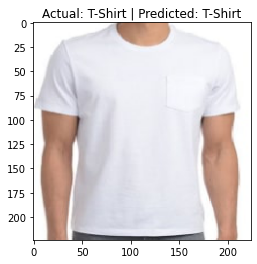

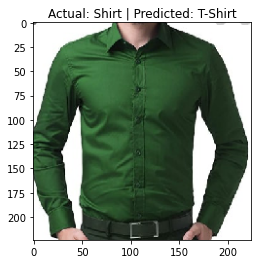

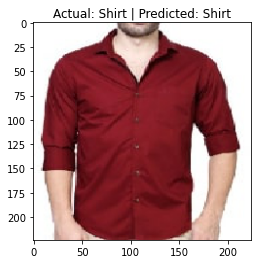

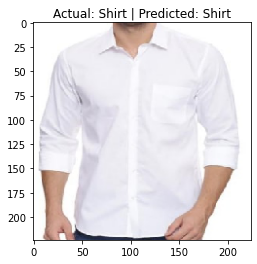

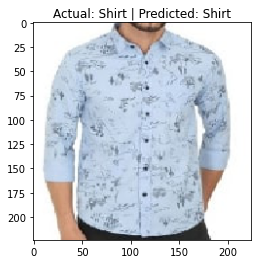

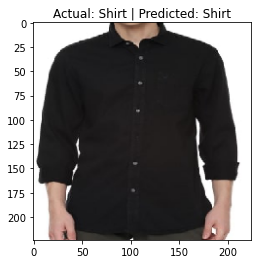

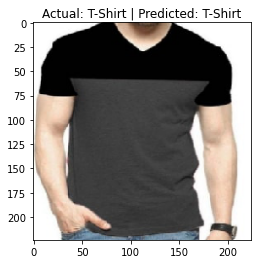

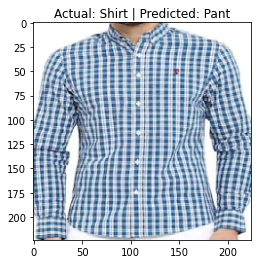

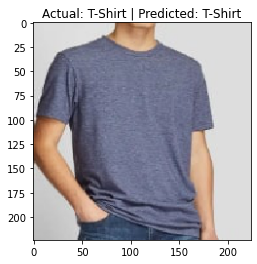

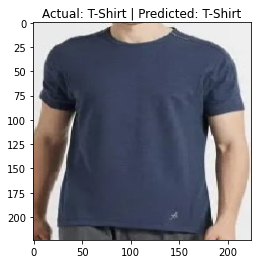

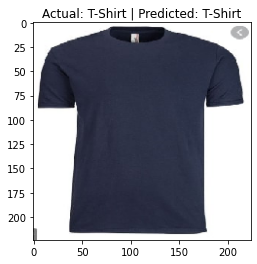

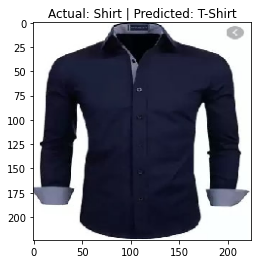

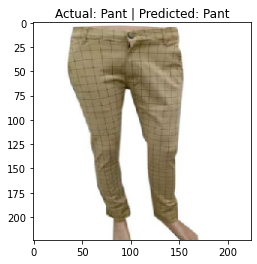

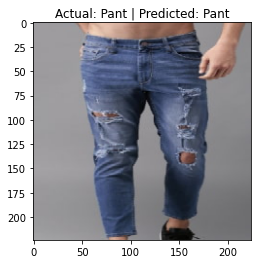

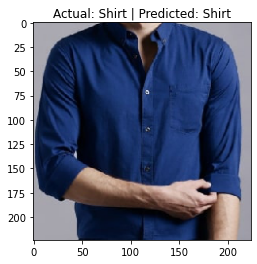

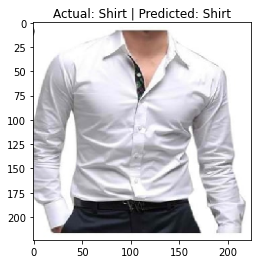

In [58]:
for result, image in zip(pred_results, pred_imgs):
    plt.figure()
    plt.title(f"Actual: {result[0]} | Predicted: {result[1]}")
    plt.imshow(image)

# New Model

In [59]:
trainx2, trainy2 = shuffle(train_vecs, train_Y)
trainx2.shape, trainy2.shape
tx2, vx2, ty2, vy2 = train_test_split(trainx, trainy, test_size = 0.2)
testx2, testy2 = test_vecs.copy(), test_Y.copy()
tx2.shape, ty2.shape, vx2.shape, vy2.shape, testx2.shape, testy2.shape

((2878, 1000), (2878,), (720, 1000), (720,), (900, 1000), (900,))

In [60]:
scaler = MinMaxScaler()
tx2 = scaler.fit_transform(tx2)
vx2 = scaler.transform(vx2)
testx2 = scaler.transform(testx2)

tx2.shape, ty2.shape, vx2.shape, vy2.shape, testx2.shape, testy2.shape

((2878, 1000), (2878,), (720, 1000), (720,), (900, 1000), (900,))

In [61]:
EPOCHS = 300
BATCH_SIZE = 100
LEARNING_RATE = 0.00007
NUM_FEATURES = 1000
NUM_CLASSES = NUM_OUTPUTS

In [62]:
class MulticlassClassification2(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification2, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 256)
        self.layer_4 = nn.Linear(256, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [64]:
torch_model2 = MulticlassClassification2(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
torch_model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model2.parameters(), lr=LEARNING_RATE)
print(torch_model2)



def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

MulticlassClassification2(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [65]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset2 = ClassifierDataset(torch.from_numpy(tx2).float(), torch.from_numpy(ty2).long())
val_dataset2 = ClassifierDataset(torch.from_numpy(vx2).float(), torch.from_numpy(vy2).long())
test_dataset2 = ClassifierDataset(torch.from_numpy(testx2).float(), torch.from_numpy(testy2).long())

train_loader2 = DataLoader(dataset=train_dataset2,
                          batch_size=BATCH_SIZE
)
val_loader2 = DataLoader(dataset=val_dataset2, batch_size=1)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=1)

In [66]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    torch_model2.train()
    for X_train_batch, y_train_batch in train_loader2:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = torch_model2(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        torch_model2.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = torch_model2(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.96164 | Val Loss: 1.07866 | Train Acc: 75.862| Val Acc: 35.972
Epoch 002: | Train Loss: 0.70624 | Val Loss: 0.79973 | Train Acc: 100.000| Val Acc: 82.639
Epoch 003: | Train Loss: 0.56809 | Val Loss: 0.53281 | Train Acc: 100.000| Val Acc: 88.472
Epoch 004: | Train Loss: 0.46320 | Val Loss: 0.43847 | Train Acc: 100.000| Val Acc: 90.556
Epoch 005: | Train Loss: 0.38596 | Val Loss: 0.37460 | Train Acc: 100.000| Val Acc: 91.944
Epoch 006: | Train Loss: 0.33902 | Val Loss: 0.32665 | Train Acc: 100.000| Val Acc: 92.639
Epoch 007: | Train Loss: 0.28968 | Val Loss: 0.29037 | Train Acc: 100.000| Val Acc: 93.472
Epoch 008: | Train Loss: 0.25928 | Val Loss: 0.26507 | Train Acc: 100.000| Val Acc: 94.583
Epoch 009: | Train Loss: 0.23248 | Val Loss: 0.24034 | Train Acc: 100.000| Val Acc: 95.000
Epoch 010: | Train Loss: 0.20918 | Val Loss: 0.22359 | Train Acc: 100.000| Val Acc: 95.139
Epoch 011: | Train Loss: 0.19394 | Val Loss: 0.20577 | Train Acc: 100.000| Val Acc: 95.556


Epoch 092: | Train Loss: 0.00676 | Val Loss: 0.07145 | Train Acc: 100.000| Val Acc: 98.194
Epoch 093: | Train Loss: 0.00595 | Val Loss: 0.07550 | Train Acc: 100.000| Val Acc: 98.333
Epoch 094: | Train Loss: 0.00712 | Val Loss: 0.07830 | Train Acc: 100.000| Val Acc: 98.611
Epoch 095: | Train Loss: 0.00756 | Val Loss: 0.08178 | Train Acc: 100.000| Val Acc: 98.472
Epoch 096: | Train Loss: 0.00691 | Val Loss: 0.08286 | Train Acc: 100.000| Val Acc: 98.194
Epoch 097: | Train Loss: 0.00779 | Val Loss: 0.08391 | Train Acc: 100.000| Val Acc: 98.194
Epoch 098: | Train Loss: 0.00785 | Val Loss: 0.08069 | Train Acc: 100.000| Val Acc: 98.194
Epoch 099: | Train Loss: 0.00900 | Val Loss: 0.08441 | Train Acc: 100.000| Val Acc: 98.194
Epoch 100: | Train Loss: 0.00793 | Val Loss: 0.08117 | Train Acc: 100.000| Val Acc: 98.194
Epoch 101: | Train Loss: 0.00807 | Val Loss: 0.08063 | Train Acc: 100.000| Val Acc: 98.333
Epoch 102: | Train Loss: 0.00618 | Val Loss: 0.07552 | Train Acc: 100.000| Val Acc: 98.194

Epoch 183: | Train Loss: 0.01085 | Val Loss: 0.08525 | Train Acc: 100.000| Val Acc: 98.056
Epoch 184: | Train Loss: 0.00680 | Val Loss: 0.08980 | Train Acc: 100.000| Val Acc: 98.194
Epoch 185: | Train Loss: 0.00376 | Val Loss: 0.08473 | Train Acc: 100.000| Val Acc: 98.333
Epoch 186: | Train Loss: 0.00285 | Val Loss: 0.08345 | Train Acc: 100.000| Val Acc: 98.333
Epoch 187: | Train Loss: 0.00239 | Val Loss: 0.08405 | Train Acc: 100.000| Val Acc: 98.333
Epoch 188: | Train Loss: 0.00357 | Val Loss: 0.08310 | Train Acc: 100.000| Val Acc: 98.472
Epoch 189: | Train Loss: 0.00635 | Val Loss: 0.08359 | Train Acc: 100.000| Val Acc: 98.333
Epoch 190: | Train Loss: 0.00391 | Val Loss: 0.07852 | Train Acc: 100.000| Val Acc: 98.194
Epoch 191: | Train Loss: 0.00363 | Val Loss: 0.08435 | Train Acc: 100.000| Val Acc: 98.194
Epoch 192: | Train Loss: 0.00185 | Val Loss: 0.07959 | Train Acc: 100.000| Val Acc: 98.333
Epoch 193: | Train Loss: 0.00230 | Val Loss: 0.07958 | Train Acc: 100.000| Val Acc: 98.333

Epoch 274: | Train Loss: 0.00038 | Val Loss: 0.10110 | Train Acc: 100.000| Val Acc: 98.333
Epoch 275: | Train Loss: 0.00061 | Val Loss: 0.10100 | Train Acc: 100.000| Val Acc: 98.056
Epoch 276: | Train Loss: 0.00041 | Val Loss: 0.10322 | Train Acc: 100.000| Val Acc: 98.194
Epoch 277: | Train Loss: 0.00040 | Val Loss: 0.10299 | Train Acc: 100.000| Val Acc: 98.194
Epoch 278: | Train Loss: 0.00037 | Val Loss: 0.10172 | Train Acc: 100.000| Val Acc: 98.333
Epoch 279: | Train Loss: 0.00041 | Val Loss: 0.10406 | Train Acc: 100.000| Val Acc: 98.194
Epoch 280: | Train Loss: 0.00054 | Val Loss: 0.10067 | Train Acc: 100.000| Val Acc: 98.194
Epoch 281: | Train Loss: 0.00055 | Val Loss: 0.10474 | Train Acc: 100.000| Val Acc: 98.194
Epoch 282: | Train Loss: 0.00042 | Val Loss: 0.09832 | Train Acc: 100.000| Val Acc: 98.472
Epoch 283: | Train Loss: 0.00041 | Val Loss: 0.09789 | Train Acc: 100.000| Val Acc: 98.333
Epoch 284: | Train Loss: 0.00034 | Val Loss: 0.09982 | Train Acc: 100.000| Val Acc: 98.333

In [67]:
y_pred_list = []
with torch.no_grad():
    torch_model2.eval()
    for X_batch, _ in test_loader2:
        X_batch = X_batch.to(device)
        y_test_pred = torch_model2(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(classification_report(testy, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       300
           1       0.95      0.96      0.96       300
           2       0.95      0.96      0.96       300

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [72]:
torch.save(torch_model,'/kaggle/working/torch-2-vvlarge.scaler.dict')
torch.save(torch_model.state_dict(), '/kaggle/working/torch-2-vvlarge.dict')

In [73]:
model=torch.load('/kaggle/working/torch-2-vvlarge.scaler.dict')
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
IMG_SIZE = 224
NUM_OUTPUTS = 3
classify_model = torch.load("/kaggle/working/torch-2-vvlarge.scaler.dict")

labels = ["Shirt", "TShirt", "Pants"]
# labels = ["T-shirt/top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


def tag(image):
  image = image.resize((IMG_SIZE, IMG_SIZE))
  image = np.array(image)
  img_batch = np.expand_dims(image, axis=0)
  processed_batch = preprocess_input(img_batch, mode="caffe")
  vec_batch = resnet50_model.predict(processed_batch)
  vec_batch = torch.Tensor(vec_batch)
  print(vec_batch)
  pred_batch = classify_model(vec_batch)
  y_pred_softmax = torch.log_softmax(pred_batch, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
  pred = y_pred_tags.cpu().numpy()
  prediction = pred[0]
  print(prediction)

  print(f'{prediction} - { labels[prediction] }')

  return {"tag": str(prediction), "label": labels[prediction]}

In [ ]:
from flask import jsonify
img = image.load_img(f'/kaggle/input/test-image/images/test25.JPG', target_size=(IMG_SIZE, IMG_SIZE))
def return_price(img):
  if img is None:
    return jsonify({"error": "no image provided"})
  img = img.convert("RGB")

  return tag(img)
return_price(img)

In [ ]:
def load_img(names):
    print(names)
    imgs = []
    for i, image_name in enumerate(names):
        if i% 50 == 0 :
            print(f"Loading Image {i}")
        img = image.load_img(f'/kaggle/input/test-image/images/test{image_name}.jpg', target_size=(IMG_SIZE, IMG_SIZE))
        if img is None:
            continue
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [ ]:
pred_imgs = load_img(list(range(1,17)))
pred_imgs.shape

In [ ]:
pred_vecs = get_vectors(pred_imgs)
print(pred_vecs)

In [ ]:
vec_batch = torch.from_numpy(pred_vecs).float()
pred_batch = classify_model(vec_batch)
y_pred_softmax = torch.log_softmax(pred_batch, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
pred = y_pred_tags.cpu().numpy()
print(pred)
map_to_names = lambda x: map(lambda y: "Shirt" if y == 0 else "T-Shirt" if y == 1 else "Pant", x)
pred_results = list(zip(map_to_names([1,0,0,0,0,0,1,0,1,1,1,0,2,2,0,0]), map_to_names(pred)))
print(pred_results)

In [ ]:
for result, image in zip(pred_results, pred_imgs):
    plt.figure()
    plt.title(f"Actual: {result[0]} | Predicted: {result[1]}")
    plt.imshow(image)
    